# 3D Phantom

We create a Magrittetorch model from a snapshot of 3D Phantom hydrodynamics simulation.
The hydro model was kindly provided by Jolien Malfait.
The Phantom binary files are used directly, and are loaded using the [plons](https://plons.readthedocs.io) package.

## Setup

Import the required functionalty.

In [1]:
import magrittetorch.tools.radiativetransferutils as rtutils
import magrittetorch.tools.setup as setup
import torch
from magrittetorch.model.model import Model # Model class
from magrittetorch.model.geometry.geometry import GeometryType # GeometryType enum
from magrittetorch.model.geometry.boundary import BoundaryType # BoundaryType enum
# import magritte.core  as magritte             # Core functionality
import plons                                  # Loading phantom data
import numpy          as np                   # Data structures
import warnings                               # Hide warnings
warnings.filterwarnings('ignore')             # especially for yt
import yt                                     # 3D plotting
import os

from tqdm           import tqdm               # Progress bars
from astropy        import constants, units   # Unit conversions
from scipy.spatial  import Delaunay           # Finding neighbors
from yt.funcs       import mylog              # To avoid yt output 
mylog.setLevel(40)                            # as error messages

Define a working directory (you will have to change this; it must be an **absolute path**).

In [2]:
wdir = "/lhome/thomasc/Magrittetorch-examples/Phantom_3D/"

Create the working directory.

In [3]:
!mkdir -p $wdir

Define file names.

In [4]:
dump_file  = os.path.join(wdir, 'model_Phantom_3D'     )   # Phantom full dump (snapshot)
setup_file = os.path.join(wdir, 'wind.setup'           )   # Phantom setup file
input_file = os.path.join(wdir, 'wind.in'              )   # Phantom input file
model_file = os.path.join(wdir, 'model_Phantom_3D.hdf5')   # Resulting Magritte model
lamda_file = os.path.join(wdir, 'co.txt'               )   # Line data file

We use a snapshot and data file that can be downloaded with the following links.

In [5]:
dump_link  = "https://github.com/Ensor-code/phantom-models/raw/main/Malfait+2021/v05e50/wind_v05e50"
setup_link = "https://raw.githubusercontent.com/Ensor-code/phantom-models/main/Malfait%2B2021/v05e50/wind.setup"
input_link = "https://raw.githubusercontent.com/Ensor-code/phantom-models/main/Malfait%2B2021/v05e50/wind.in"
lamda_link = "https://home.strw.leidenuniv.nl/~moldata/datafiles/co.dat"

Dowload the snapshot and the linedata (``%%capture`` is just used to suppress the output).

In [6]:
%%capture
!wget $dump_link  --output-document $dump_file
!wget $setup_link --output-document $setup_file
!wget $input_link --output-document $input_file
!wget $lamda_link --output-document $lamda_file

## Extract data

The script below extracts the required data from the snapshot `phantom dump` file.

In [7]:
# Loading the data
setupData = plons.LoadSetup(wdir, "wind")
dumpData  = plons.LoadFullDump(dump_file, setupData)

position = dumpData["position"]*units.cm # position vectors [cm]
velocity = dumpData["velocity"]*units.km/units.s # velocity vectors [km/s]
rho      = dumpData["rho"]*units.g/units.cm**3 # density [g/cm^3]
u        = dumpData["u"] # internal energy density [erg/g]
tmp      = dumpData["Tgas"]*units.K # temperature [K]
tmp[tmp<2.725*units.K] = 2.725*units.K # Cut-off temperatures below 2.725 K

# Extract the number of points
npoints = len(rho)

# Convert rho (total density) to abundances
nH2 = rho * constants.N_A / (2.02 * units.g / units.mol)
nCO = nH2 * 1.0e-4

# Define turbulence at 150 m/s
trb = 150.0*units.m/units.s

In [8]:
# Extract Delaunay vertices (= Voronoi neighbors)
delaunay = Delaunay(position)
(indptr, indices) = delaunay.vertex_neighbor_vertices
neighbors = [indices[indptr[k]:indptr[k+1]] for k in range(npoints)]
nbs       = [n for sublist in neighbors for n in sublist]
n_nbs     = [len(sublist) for sublist in neighbors]

# Compute the indices of the boundary particles of the mesh, extracted from the Delaunay vertices
boundary = set([])
for i in tqdm(range(delaunay.neighbors.shape[0])):
    for k in range(4):
        if (delaunay.neighbors[i][k] == -1):
            nk1,nk2,nk3 = (k+1)%4, (k+2)%4, (k+3)%4 
            boundary.add(delaunay.simplices[i][nk1])
            boundary.add(delaunay.simplices[i][nk2])
            boundary.add(delaunay.simplices[i][nk3])
            
boundary = list(boundary)
boundary = np.array(boundary)

# The above calculation turned out to be unsatisfactory.
# Since the outer boundary is assumed to be a sphere,
# we add all points which fall inside the boundary defined above.
b_nms = np.linalg.norm(position[boundary], axis=1)
p_nms = np.linalg.norm(position,           axis=1)
boundary = np.array([i[0] for i in np.argwhere(p_nms >= np.min(b_nms))])
#convert to torch tensor
boundary_torch = torch.from_numpy(boundary)
nbs_torch = torch.Tensor(nbs).type(torch.int64)
n_nbs_torch = torch.Tensor(n_nbs).type(torch.int64)

100%|██████████| 6960643/6960643 [00:32<00:00, 213188.65it/s]


## Create model

Now all data is read, we can use it to construct a Magrittetorch model.

<div class="alert alert-warning">

Warning

Including all radiative transitions can be computationally expensive (both in time and memory cost) for self-consistent NLTE radiative transfer. For LTE radiative transfer, this is not the case, altough if one wants to image a specific line, that line must be in the list of considered transitions. For these examples, we include the first 10 radiative transitions of CO (J=1-0 to J=10-9). To consider all transitions, use `setup.set_linedata_from_LAMDA_file` as in the commented line below it.

</div>

In [9]:
model = Model(model_file) # Create model object
model.geometry.geometryType.set(GeometryType.General3D) # This is a 3D model
model.geometry.boundary.boundaryType.set(BoundaryType.Sphere3D) # With a spherical boundary

# In order to make unit conversions trivial, we use astropy quantities as input
model.geometry.points.position.set_astropy(position) # Set point positions
model.geometry.points.velocity.set_astropy(velocity) # Set point velocities
model.chemistry.species.abundance.set_astropy(np.stack([nCO, nH2, np.zeros(npoints)/units.m**3], axis=1))# Set species number densities
model.chemistry.species.symbol.set(np.array(['CO', 'H2', 'e-'], dtype='S')) #Set species symbols; should correspond to the LAMDA file format
#Note: the dtype='S' is necessary to correctly save and read the species symbols to/from the hdf5 file

model.thermodynamics.temperature.gas.set_astropy(tmp) # Set gas temperature
model.thermodynamics.turbulence.vturb.set_astropy(trb*np.ones(npoints)) # Set turbulence velocity

# Set the neighbors
model.geometry.points.neighbors.set(nbs_torch) # Set neighbors
model.geometry.points.n_neighbors.set(n_nbs_torch) # Set number of neighbors
model.geometry.boundary.boundary2point.set(boundary_torch) # Set which points are boundary points

# # For unitless quantities, we can also directly set the torch tensors
# nb_boundary = len(boundary)
# boundary_indices = torch.arange(nb_boundary, dtype = torch.int64)
# model.geometry.boundary.boundary2point.set(boundary_indices) # Set which points are boundary points
# model = setup.set_Delaunay_neighbor_lists (model) # Automatically computes and sets neighbors for each point, using a Delaunay triangulation

# Conveniently, the remeshing function puts the boundary points in front of the positions array
model = setup.set_boundary_condition_CMB  (model) # Set CMB as boundary condition
model = setup.set_uniform_rays            (model, 12) # Number of rays for NLTE raytracing; has be of the form 12*2**n

#As this example does not do NLTE, we might as well only consider the first 10 transitions of CO
model = setup.set_linedata_from_LAMDA_file(model, lamda_file, {'considered transitions': [i for i in range(10)]})
# model = setup.set_linedata_from_LAMDA_file(model, lamda_file)   # Consider all transitions
model = setup.set_quadrature              (model, 7) # Set number of frequency quadrature points for NLTE radiative transfer

model.write()

Not considering all radiative transitions on the data file but only the specified ones!
Writing model to:  /lhome/thomasc/Magrittetorch-examples/Phantom_3D/model_Phantom_3D.hdf5


## Plot model

Load the data in a `yt` unstructured mesh.

In [10]:
ds = yt.load_unstructured_mesh(
    connectivity = delaunay.simplices.astype(np.int64),
    coordinates  = position.to_value(units.cm), # yt expects cm not m 
    node_data    = {('connect1', 'n'): nCO[delaunay.simplices].to_value(units.m**-3)}
)

Plot a slice through the mesh orthogonal to the z-axis.


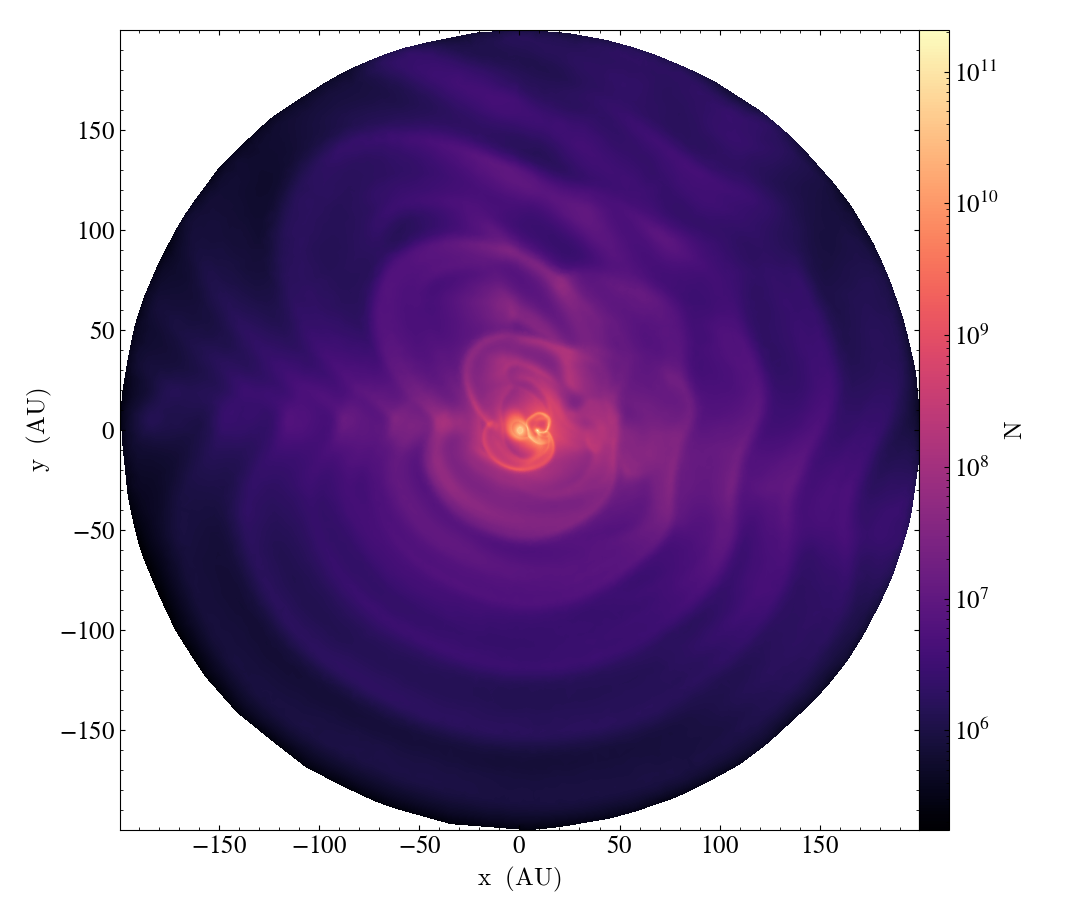

In [11]:
sl = yt.SlicePlot (ds, 'z', ('connect1', 'n'))
sl.set_cmap       (('connect1', 'n'), 'magma')
sl.zoom           (1.1)

Show mesh on the plot.


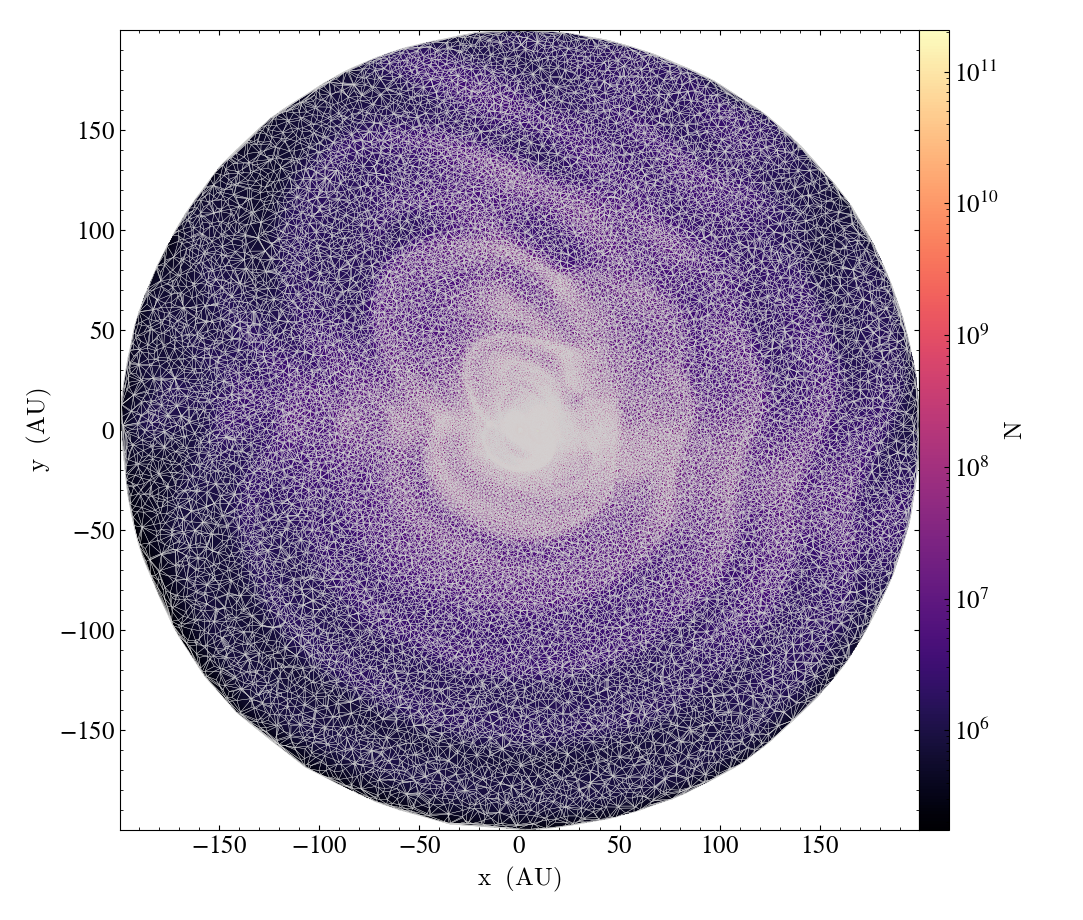

In [12]:
sl = yt.SlicePlot      (ds, 'z', ('connect1', 'n'))
sl.set_cmap            (('connect1', 'n'), 'magma')
sl.zoom                (1.1)
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.25]})

In the [next example](4_reduce_Phantom_3D.ipynb) we demonstrate how to reduce this model as in [De Ceuster et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020MNRAS.499.5194D/abstract).